<a href="https://colab.research.google.com/github/Mateus929/Facial-Expression-Recognition-Challenge/blob/main/notebooks/ConvNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation: Mounting Google Drive

As a first step, this notebook demonstrates how to mount your Google Drive to access files stored there.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading and Initial Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [3]:
# Note: Make sure the file path is correct and the file exists in your Google Drive.
# The path should be '/content/drive/MyDrive/Colab Notebooks/Facial Expression Recognition Challenge/data/your_data_file.csv'
# Replace 'your_data_file.csv' with the actual name of your training data file.
try:
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Facial Expression Recognition Challenge/data/train.csv')
    print("Training data loaded successfully!")
    display(df.head())
except FileNotFoundError:
    print("Error: The training data file was not found. Please check the file path and name.")
except Exception as e:
    print(f"An error occurred while loading the data: {e}")

Training data loaded successfully!


,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


# Data Splitting

In [4]:
import torch
from torch.utils.data import Dataset
import numpy as np
from torchvision import transforms

class FERDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixel_string = self.data.iloc[idx]['pixels']
        label = int(self.data.iloc[idx]['emotion'])

        pixels = np.array([int(p) for p in pixel_string.split()], dtype=np.uint8).reshape(48, 48)

        if self.transform:
            image = self.transform(pixels)
        else:
            image = torch.tensor(pixels, dtype=torch.float32).unsqueeze(0) / 255.0

        return image, label

In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['emotion'], random_state=42)

train_dataset = FERDataset(train_df, transform=transform)
val_dataset = FERDataset(val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print("Training DataLoader created with", len(train_loader), "batches.")
print("Validation DataLoader created with", len(val_loader), "batches.")

Training DataLoader created with 359 batches.
Validation DataLoader created with 90 batches.


It's important to visualize the distribution of the target variable (emotions) in both the training and validation datasets to ensure that the split was successful in maintaining similar proportions of each class in both sets (due to stratification). This helps to avoid bias during training and provides a better understanding of the dataset's composition.

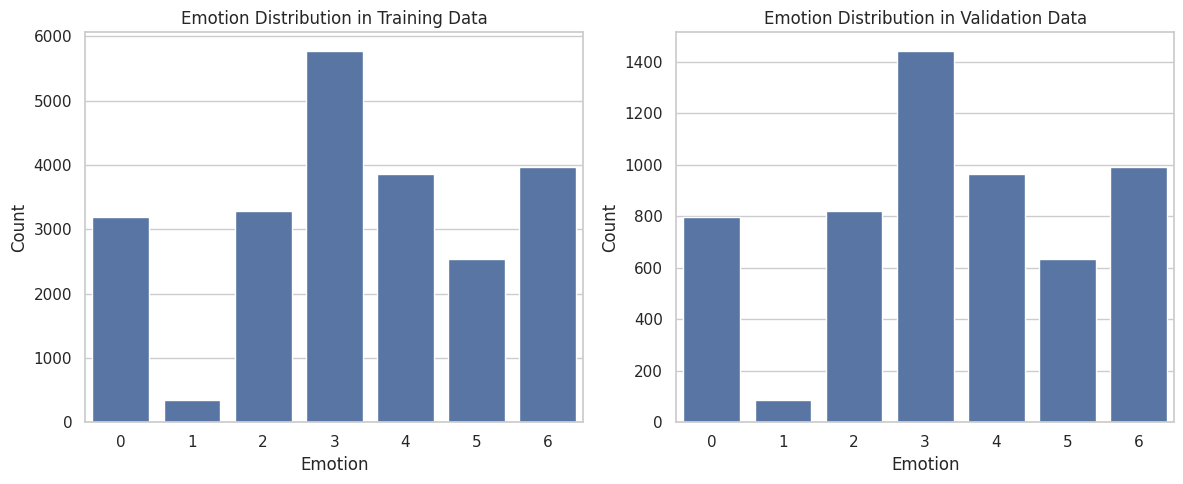

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x='emotion', data=train_df, ax=axes[0])
axes[0].set_title('Emotion Distribution in Training Data')
axes[0].set_xlabel('Emotion')
axes[0].set_ylabel('Count')

sns.countplot(x='emotion', data=val_df, ax=axes[1])
axes[1].set_title('Emotion Distribution in Validation Data')
axes[1].set_xlabel('Emotion')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Training Basic CNN Models

This section focuses on training a simple Convolutional Neural Network (CNN) model for the facial expression recognition task.

In [ ]:
!pip install wandb
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: zhorzholianimate (zhorzholianimate-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Design of Training Function

We add train function that could be used during training in feature. Also, it has build in wandb usege.

In [10]:
def train_model(model, criterion, optimizer, device, train_loader, val_loader, num_epochs=10, project_name="fer-cnn", group_name="", run_name=None):
    import wandb
    wandb.init(project=project_name, name=run_name, group=group_name)

    wandb.config.update({
        "epochs": num_epochs,
        "batch_size": train_loader.batch_size,
        "learning_rate": optimizer.param_groups[0]['lr'],
        "architecture": str(model),
    })
    wandb.watch(model, criterion, log="all", log_freq=100)

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct = 0.0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset)

        # Validation
        model.eval()
        running_val_loss, correct_val = 0.0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * labels.size(0)
                correct_val += (outputs.argmax(1) == labels).sum().item()

        val_loss = running_val_loss / len(val_loader.dataset)
        val_acc = correct_val / len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc
        })

    wandb.finish()

## Training the First Model

We will begin by training a basic CNN model, a common architecture in practice. This model will consist of two convolutional layers followed by ReLU activation and max pooling layers. After the convolutional and pooling layers, a single linear (fully connected) layer will be used for classification.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),  # (1, 48, 48) -> (32, 48, 48)
    nn.ReLU(),
    nn.MaxPool2d(2, 2),                          # (32, 24, 24)

    nn.Conv2d(32, 64, kernel_size=3, padding=1), # (64, 24, 24)
    nn.ReLU(),
    nn.MaxPool2d(2, 2),                          # (64, 12, 12)

    nn.Flatten(),                                # 64*12*12 = 9216
    nn.Linear(64 * 12 * 12, 128),
    nn.ReLU(),
    nn.Linear(128, 7)  # 7 emotion classes
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
display(model.to(device))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=9216, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=7, bias=True)
)

In [ ]:
train_model(model, criterion, optimizer, device, train_loader, val_loader, run_name='basic_run1')


Epoch 1/10 | Train Loss: 1.6095, Train Acc: 0.3706 | Val Loss: 1.4729, Val Acc: 0.4418
Epoch 2/10 | Train Loss: 1.3961, Train Acc: 0.4660 | Val Loss: 1.3701, Val Acc: 0.4760
Epoch 3/10 | Train Loss: 1.2809, Train Acc: 0.5164 | Val Loss: 1.3199, Val Acc: 0.4986
Epoch 4/10 | Train Loss: 1.1775, Train Acc: 0.5552 | Val Loss: 1.2876, Val Acc: 0.5103
Epoch 5/10 | Train Loss: 1.0822, Train Acc: 0.5965 | Val Loss: 1.3088, Val Acc: 0.5106
Epoch 6/10 | Train Loss: 0.9733, Train Acc: 0.6384 | Val Loss: 1.3309, Val Acc: 0.5155
Epoch 7/10 | Train Loss: 0.8563, Train Acc: 0.6908 | Val Loss: 1.3354, Val Acc: 0.5284
Epoch 8/10 | Train Loss: 0.7232, Train Acc: 0.7382 | Val Loss: 1.4032, Val Acc: 0.5280
Epoch 9/10 | Train Loss: 0.5930, Train Acc: 0.7893 | Val Loss: 1.5312, Val Acc: 0.5261
Epoch 10/10 | Train Loss: 0.4660, Train Acc: 0.8368 | Val Loss: 1.7513, Val Acc: 0.5152


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▄▄▅▆▇▇█
train_loss,█▇▆▅▅▄▃▃▂▁
val_accuracy,▁▄▆▇▇▇███▇
val_loss,▄▂▁▁▁▂▂▃▅█
epoch,10
train_accuracy,0.83681
train_loss,0.46597
val_accuracy,0.51515
val_loss,1.75132


## Second Model

We will construct a second model based on the best practices for CNNs as described in the [CS231n notes on Convolutional Networks](https://cs231n.github.io/convolutional-networks/).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, padding=1),  # (1, 48, 48) -> (16, 48, 48)
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),       # (16, 24, 24)

    nn.Conv2d(16, 32, kernel_size=3, padding=1), #  (32, 24, 24)
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),       # (32, 12, 12)

    nn.Flatten(),
    nn.Linear(32 * 12 * 12, 128),                 # (128)
    nn.ReLU(),
    nn.Linear(128, 7)                             # (7)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
display(model.to(device))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4608, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=7, bias=True)
)

In [ ]:
train_model(model, criterion, optimizer, device, train_loader, val_loader, run_name='basic_run2')

Epoch 1/10 | Train Loss: 1.6267, Train Acc: 0.3588 | Val Loss: 1.4716, Val Acc: 0.4321
Epoch 2/10 | Train Loss: 1.4101, Train Acc: 0.4583 | Val Loss: 1.3604, Val Acc: 0.4749
Epoch 3/10 | Train Loss: 1.2911, Train Acc: 0.5075 | Val Loss: 1.3087, Val Acc: 0.4974
Epoch 4/10 | Train Loss: 1.1941, Train Acc: 0.5482 | Val Loss: 1.2788, Val Acc: 0.5169
Epoch 5/10 | Train Loss: 1.0952, Train Acc: 0.5877 | Val Loss: 1.3080, Val Acc: 0.5186
Epoch 6/10 | Train Loss: 0.9938, Train Acc: 0.6342 | Val Loss: 1.2726, Val Acc: 0.5244
Epoch 7/10 | Train Loss: 0.8829, Train Acc: 0.6764 | Val Loss: 1.3405, Val Acc: 0.5209
Epoch 8/10 | Train Loss: 0.7656, Train Acc: 0.7226 | Val Loss: 1.4285, Val Acc: 0.5192
Epoch 9/10 | Train Loss: 0.6464, Train Acc: 0.7711 | Val Loss: 1.5226, Val Acc: 0.5134
Epoch 10/10 | Train Loss: 0.5252, Train Acc: 0.8178 | Val Loss: 1.6831, Val Acc: 0.5237


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▃▄▄▅▆▇▇█
train_loss,█▇▆▅▅▄▃▃▂▁
val_accuracy,▁▄▆▇████▇█
val_loss,▄▂▂▁▂▁▂▄▅█
epoch,10
train_accuracy,0.81778
train_loss,0.52518
val_accuracy,0.52369
val_loss,1.68307


## Third Model

We will now test one more basic model.

In [ ]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, padding=1),   # (1,48,48) -> (8,48,48)
    nn.ReLU(),
    nn.Conv2d(8, 16, kernel_size=3, padding=1),  # (8,48,48) -> (16,48,48)
    nn.ReLU(),
    nn.MaxPool2d(2, 2),                          # (16,48,48) -> (16,24,24)

    nn.Conv2d(16, 32, kernel_size=3, padding=1), # (16,24,24) -> (32,24,24)
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, padding=1), # (32,24,24) -> (32,24,24)
    nn.ReLU(),
    nn.MaxPool2d(2, 2),                          # (32,24,24) -> (32,12,12)

    nn.Conv2d(32, 64, kernel_size=3, padding=1), # (32,12,12) -> (64,12,12)
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1), # (64,12,12) -> (64,12,12)
    nn.ReLU(),
    nn.MaxPool2d(2, 2),                          # (64,12,12) -> (64,6,6)

    nn.Flatten(),
    nn.Linear(64 * 6 * 6, 128),                  # 2304 -> 128
    nn.ReLU(),
    nn.Linear(128, 64),                          # 128 -> 64
    nn.ReLU(),
    nn.Linear(64, 7)                             # 64 -> 7 output classes
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
display(model.to(device))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, criterion, optimizer, device, train_loader, val_loader, run_name='basic_run_3')

Using device: cuda


Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=2304, out_features=128, bias=True)
  (17): ReLU()
  (18): Linear(in_features=128, out_features=64, bias=True)
  (19): ReLU()
  (20): Linear(in_feature

Epoch 1/10 | Train Loss: 1.7901, Train Acc: 0.2613 | Val Loss: 1.6941, Val Acc: 0.3049
Epoch 2/10 | Train Loss: 1.5740, Train Acc: 0.3861 | Val Loss: 1.4581, Val Acc: 0.4326
Epoch 3/10 | Train Loss: 1.4009, Train Acc: 0.4590 | Val Loss: 1.3430, Val Acc: 0.4852
Epoch 4/10 | Train Loss: 1.2991, Train Acc: 0.5012 | Val Loss: 1.2626, Val Acc: 0.5178
Epoch 5/10 | Train Loss: 1.2131, Train Acc: 0.5364 | Val Loss: 1.2332, Val Acc: 0.5301
Epoch 6/10 | Train Loss: 1.1362, Train Acc: 0.5682 | Val Loss: 1.2244, Val Acc: 0.5361
Epoch 7/10 | Train Loss: 1.0565, Train Acc: 0.5979 | Val Loss: 1.2143, Val Acc: 0.5455
Epoch 8/10 | Train Loss: 0.9801, Train Acc: 0.6300 | Val Loss: 1.1927, Val Acc: 0.5554
Epoch 9/10 | Train Loss: 0.9028, Train Acc: 0.6616 | Val Loss: 1.2457, Val Acc: 0.5529
Epoch 10/10 | Train Loss: 0.8299, Train Acc: 0.6896 | Val Loss: 1.2681, Val Acc: 0.5543


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▇▇██
train_loss,█▆▅▄▄▃▃▂▂▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▅▃▂▂▁▁▁▂▂
epoch,10
train_accuracy,0.68955
train_loss,0.82994
val_accuracy,0.55434
val_loss,1.26808


CPU times: user 5min 44s, sys: 5.4 s, total: 5min 49s
Wall time: 5min 53s


# Train Models

As observed from the previous runs, Model 3 achieved the best results on the validation set. We will focus on improving this model further. It's also worth noting that Model 3 exhibited minimal overfitting, likely due to its more aggressive architecture compared to the first two models. However, it still shows signs of overfitting, and in the following steps, we aim to address this to create a better architecture.

## Dropout

First, we will add dropout layers as they are effective in dealing with overfitting.

In [ ]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, padding=1),   # (1,48,48) -> (8,48,48)
    nn.ReLU(),
    nn.Conv2d(8, 16, kernel_size=3, padding=1),  # (8,48,48) -> (16,48,48)
    nn.ReLU(),
    nn.MaxPool2d(2, 2),                          # (16,48,48) -> (16,24,24)

    nn.Conv2d(16, 32, kernel_size=3, padding=1), # (16,24,24) -> (32,24,24)
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, padding=1), # (32,24,24) -> (32,24,24)
    nn.ReLU(),
    nn.MaxPool2d(2, 2),                          # (32,24,24) -> (32,12,12)

    nn.Conv2d(32, 64, kernel_size=3, padding=1), # (32,12,12) -> (64,12,12)
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1), # (64,12,12) -> (64,12,12)
    nn.ReLU(),
    nn.MaxPool2d(2, 2),                          # (64,12,12) -> (64,6,6)

    nn.Flatten(),
    nn.Linear(64 * 6 * 6, 128),                  # 2304 -> 128
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 64),                          # 128 -> 64
    nn.ReLU(),
    nn.Linear(64, 7)                             # 64 -> 7 output classes
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, criterion, optimizer, device, train_loader, val_loader, group_name="DefaultCnnNet", run_name='dropout1.0')

Using device: cuda


Epoch 1/10 | Train Loss: 1.8108, Train Acc: 0.2487 | Val Loss: 1.7761, Val Acc: 0.2513
Epoch 2/10 | Train Loss: 1.7130, Train Acc: 0.3024 | Val Loss: 1.5903, Val Acc: 0.3762
Epoch 3/10 | Train Loss: 1.5626, Train Acc: 0.3893 | Val Loss: 1.4750, Val Acc: 0.4296
Epoch 4/10 | Train Loss: 1.4698, Train Acc: 0.4273 | Val Loss: 1.4032, Val Acc: 0.4460
Epoch 5/10 | Train Loss: 1.3960, Train Acc: 0.4554 | Val Loss: 1.3302, Val Acc: 0.4847
Epoch 6/10 | Train Loss: 1.3282, Train Acc: 0.4858 | Val Loss: 1.2797, Val Acc: 0.5021
Epoch 7/10 | Train Loss: 1.2773, Train Acc: 0.5086 | Val Loss: 1.2602, Val Acc: 0.5165
Epoch 8/10 | Train Loss: 1.2392, Train Acc: 0.5225 | Val Loss: 1.2455, Val Acc: 0.5265
Epoch 9/10 | Train Loss: 1.1958, Train Acc: 0.5390 | Val Loss: 1.2233, Val Acc: 0.5303
Epoch 10/10 | Train Loss: 1.1549, Train Acc: 0.5571 | Val Loss: 1.1935, Val Acc: 0.5448


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▄▅▆▆▇▇██
train_loss,█▇▅▄▄▃▂▂▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▆▄▄▃▂▂▂▁▁
epoch,10
train_accuracy,0.55706
train_loss,1.15493
val_accuracy,0.54476
val_loss,1.19346


CPU times: user 5min 38s, sys: 5.33 s, total: 5min 43s
Wall time: 5min 45s


We will try the same approach on the second base model. This is because the model, in its current form, may not be complex enough.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, padding=1),  # (1, 48, 48) -> (16, 48, 48)
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),       # (16, 24, 24)

    nn.Conv2d(16, 32, kernel_size=3, padding=1), # (32, 24, 24)
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),       # (32, 12, 12)

    nn.Flatten(),
    nn.Linear(32 * 12 * 12, 128),                 # 4608 -> 128
    nn.ReLU(),
    nn.Dropout(p=0.5),                            # Dropout added here
    nn.Linear(128, 7)                             # 128 -> 7
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, criterion, optimizer, device, train_loader, val_loader, group_name="DefaultCnnNet", run_name='dropout2.0')

Using device: cuda


Epoch 1/10 | Train Loss: 1.6887, Train Acc: 0.3267 | Val Loss: 1.5366, Val Acc: 0.4159
Epoch 2/10 | Train Loss: 1.5068, Train Acc: 0.4147 | Val Loss: 1.4002, Val Acc: 0.4648
Epoch 3/10 | Train Loss: 1.4165, Train Acc: 0.4574 | Val Loss: 1.3385, Val Acc: 0.4862
Epoch 4/10 | Train Loss: 1.3423, Train Acc: 0.4859 | Val Loss: 1.3175, Val Acc: 0.5056
Epoch 5/10 | Train Loss: 1.2903, Train Acc: 0.5060 | Val Loss: 1.2870, Val Acc: 0.5106
Epoch 6/10 | Train Loss: 1.2370, Train Acc: 0.5296 | Val Loss: 1.2632, Val Acc: 0.5240
Epoch 7/10 | Train Loss: 1.1914, Train Acc: 0.5460 | Val Loss: 1.2591, Val Acc: 0.5270
Epoch 8/10 | Train Loss: 1.1364, Train Acc: 0.5682 | Val Loss: 1.2552, Val Acc: 0.5193
Epoch 9/10 | Train Loss: 1.0915, Train Acc: 0.5877 | Val Loss: 1.2604, Val Acc: 0.5340
Epoch 10/10 | Train Loss: 1.0400, Train Acc: 0.6035 | Val Loss: 1.2561, Val Acc: 0.5291


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▄▃▃▂▂▁
val_accuracy,▁▄▅▆▇▇█▇██
val_loss,█▅▃▃▂▁▁▁▁▁
epoch,10
train_accuracy,0.60347
train_loss,1.04001
val_accuracy,0.52908
val_loss,1.25615


Train accuracy is too low, implying dropout probability is too high. So choosing p=0.2 seems a better choice.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, padding=1),  # (1, 48, 48) -> (16, 48, 48)
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),       # (16, 24, 24)

    nn.Conv2d(16, 32, kernel_size=3, padding=1), # (32, 24, 24)
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),       # (32, 12, 12)

    nn.Flatten(),
    nn.Linear(32 * 12 * 12, 128),                 # 4608 -> 128
    nn.ReLU(),
    nn.Dropout(p=0.2),                            # Dropout added here
    nn.Linear(128, 7)                             # 128 -> 7
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, criterion, optimizer, device, train_loader, val_loader, group_name="DefaultCnnNet", run_name='dropout2.1')

Using device: cuda


Epoch 1/10 | Train Loss: 1.6379, Train Acc: 0.3522 | Val Loss: 1.5012, Val Acc: 0.4148
Epoch 2/10 | Train Loss: 1.4348, Train Acc: 0.4510 | Val Loss: 1.3838, Val Acc: 0.4742
Epoch 3/10 | Train Loss: 1.3280, Train Acc: 0.4940 | Val Loss: 1.3085, Val Acc: 0.4948
Epoch 4/10 | Train Loss: 1.2461, Train Acc: 0.5245 | Val Loss: 1.2838, Val Acc: 0.5044
Epoch 5/10 | Train Loss: 1.1624, Train Acc: 0.5602 | Val Loss: 1.2606, Val Acc: 0.5225
Epoch 6/10 | Train Loss: 1.0830, Train Acc: 0.5923 | Val Loss: 1.2618, Val Acc: 0.5253
Epoch 7/10 | Train Loss: 1.0012, Train Acc: 0.6232 | Val Loss: 1.3006, Val Acc: 0.5200
Epoch 8/10 | Train Loss: 0.9257, Train Acc: 0.6569 | Val Loss: 1.2916, Val Acc: 0.5336
Epoch 9/10 | Train Loss: 0.8399, Train Acc: 0.6911 | Val Loss: 1.2932, Val Acc: 0.5334
Epoch 10/10 | Train Loss: 0.7597, Train Acc: 0.7165 | Val Loss: 1.3991, Val Acc: 0.5317


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▄▅▆▆▇██
train_loss,█▆▆▅▄▄▃▂▂▁
val_accuracy,▁▅▆▆▇█▇███
val_loss,█▅▂▂▁▁▂▂▂▅
epoch,10
train_accuracy,0.71655
train_loss,0.75968
val_accuracy,0.5317
val_loss,1.39907


Despite addressing overfitting with dropout, it appears to negatively impact validation performance, suggesting a potential issue with bias as well. To tackle this, we will increase the model's complexity and adjust the dropout parameters.

In [ ]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),   # (64, 24, 24)

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),   # (128, 12, 12)

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),   # (256, 6, 6)

    nn.Flatten(),                            # flatten to (256*6*6 = 9216)
    nn.Dropout(0.5),

    nn.Linear(256 * 6 * 6, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),

    nn.Linear(1024, 7)
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, criterion, optimizer, device, train_loader, val_loader, group_name="DefaultCnnNet", run_name='dropout_2.3')

Using device: cuda


Epoch 1/10 | Train Loss: 1.7070, Train Acc: 0.3106 | Val Loss: 1.5088, Val Acc: 0.4086
Epoch 2/10 | Train Loss: 1.4306, Train Acc: 0.4479 | Val Loss: 1.3330, Val Acc: 0.4866
Epoch 3/10 | Train Loss: 1.2855, Train Acc: 0.5037 | Val Loss: 1.2553, Val Acc: 0.5103
Epoch 4/10 | Train Loss: 1.1943, Train Acc: 0.5480 | Val Loss: 1.1699, Val Acc: 0.5651
Epoch 5/10 | Train Loss: 1.1290, Train Acc: 0.5719 | Val Loss: 1.1324, Val Acc: 0.5784
Epoch 6/10 | Train Loss: 1.0631, Train Acc: 0.5992 | Val Loss: 1.1005, Val Acc: 0.5822
Epoch 7/10 | Train Loss: 0.9981, Train Acc: 0.6201 | Val Loss: 1.0867, Val Acc: 0.5911
Epoch 8/10 | Train Loss: 0.9438, Train Acc: 0.6417 | Val Loss: 1.0635, Val Acc: 0.5965
Epoch 9/10 | Train Loss: 0.8823, Train Acc: 0.6660 | Val Loss: 1.0767, Val Acc: 0.6014
Epoch 10/10 | Train Loss: 0.8288, Train Acc: 0.6883 | Val Loss: 1.0673, Val Acc: 0.6097


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
train_accuracy,0.68834
train_loss,0.82883
val_accuracy,0.60972
val_loss,1.0673


CPU times: user 7min 11s, sys: 9.4 s, total: 7min 21s
Wall time: 7min 9s


In [ ]:
print("Gradient norms per layer:")
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f"{name:30} | grad norm: {param.grad.norm().item():.6f}")
    else:
        print(f"{name:30} | no grad")

Gradient norms per layer:
0.weight                       | grad norm: 0.825176
0.bias                         | grad norm: 0.515651
2.weight                       | grad norm: 0.706366
2.bias                         | grad norm: 0.248744
5.weight                       | grad norm: 1.061722
5.bias                         | grad norm: 0.345760
7.weight                       | grad norm: 0.856313
7.bias                         | grad norm: 0.295130
10.weight                      | grad norm: 1.173837
10.bias                        | grad norm: 0.366692
15.weight                      | grad norm: 0.773228
15.bias                        | grad norm: 0.078975
18.weight                      | grad norm: 1.422204
18.bias                        | grad norm: 0.112807


Add one more layer to make the architecture more complex. In order to increase the training score, increase the dropout parameter.

In [ ]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),   # (64, 24, 24)

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),   # (128, 12, 12)

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),   # (256, 6, 6)

    nn.Flatten(),                            # flatten to (256*6*6 = 9216)
    nn.Dropout(0.3),

    nn.Linear(256 * 6 * 6, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),

    nn.Linear(1024, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),

    nn.Linear(512, 7)
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, criterion, optimizer, device, train_loader, val_loader, group_name="DefaultCnnNet", run_name='dropout_2.5')

Using device: cuda


Epoch 1/10 | Train Loss: 1.7369, Train Acc: 0.2934 | Val Loss: 1.5508, Val Acc: 0.3868
Epoch 2/10 | Train Loss: 1.4628, Train Acc: 0.4319 | Val Loss: 1.3090, Val Acc: 0.5005
Epoch 3/10 | Train Loss: 1.3069, Train Acc: 0.4971 | Val Loss: 1.2127, Val Acc: 0.5301
Epoch 4/10 | Train Loss: 1.1986, Train Acc: 0.5428 | Val Loss: 1.2113, Val Acc: 0.5402
Epoch 5/10 | Train Loss: 1.1071, Train Acc: 0.5807 | Val Loss: 1.1336, Val Acc: 0.5653
Epoch 6/10 | Train Loss: 1.0184, Train Acc: 0.6150 | Val Loss: 1.1024, Val Acc: 0.5888
Epoch 7/10 | Train Loss: 0.9319, Train Acc: 0.6471 | Val Loss: 1.1041, Val Acc: 0.5859
Epoch 8/10 | Train Loss: 0.8465, Train Acc: 0.6825 | Val Loss: 1.1224, Val Acc: 0.5820
Epoch 9/10 | Train Loss: 0.7567, Train Acc: 0.7174 | Val Loss: 1.1614, Val Acc: 0.5902
Epoch 10/10 | Train Loss: 0.6832, Train Acc: 0.7480 | Val Loss: 1.1557, Val Acc: 0.5897


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▆▇██
train_loss,█▆▅▄▄▃▃▂▁▁
val_accuracy,▁▅▆▆▇█████
val_loss,█▄▃▃▁▁▁▁▂▂
epoch,10
train_accuracy,0.74799
train_loss,0.68315
val_accuracy,0.58969
val_loss,1.15568


CPU times: user 7min 14s, sys: 9.62 s, total: 7min 23s
Wall time: 7min 11s


Build more complex model.

In [ ]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    # nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    # nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # -> (64, 24, 24)

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    # nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    # nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # -> (128, 12, 12)

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    # nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, padding=1),
    # nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # -> (256, 6, 6)

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    # nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, kernel_size=3, padding=1),
    # nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # -> (512, 3, 3)

    nn.Flatten(),                          # -> 512 * 3 * 3 = 4608
    nn.Dropout(0.3),
    nn.Linear(512 * 3 * 3, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 7)
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, criterion, optimizer, device, train_loader, val_loader, group_name="DefaultCnnNet", run_name='dropout_2.7')

Using device: cuda


Epoch 1/10 | Train Loss: 1.8047, Train Acc: 0.2443 | Val Loss: 1.7789, Val Acc: 0.2492
Epoch 2/10 | Train Loss: 1.7352, Train Acc: 0.2883 | Val Loss: 1.5844, Val Acc: 0.3927
Epoch 3/10 | Train Loss: 1.5137, Train Acc: 0.4058 | Val Loss: 1.4449, Val Acc: 0.4244
Epoch 4/10 | Train Loss: 1.3969, Train Acc: 0.4546 | Val Loss: 1.3517, Val Acc: 0.4680
Epoch 5/10 | Train Loss: 1.3066, Train Acc: 0.4937 | Val Loss: 1.2889, Val Acc: 0.5012
Epoch 6/10 | Train Loss: 1.2244, Train Acc: 0.5239 | Val Loss: 1.2642, Val Acc: 0.5110
Epoch 7/10 | Train Loss: 1.1549, Train Acc: 0.5566 | Val Loss: 1.2134, Val Acc: 0.5341
Epoch 8/10 | Train Loss: 1.0840, Train Acc: 0.5816 | Val Loss: 1.1923, Val Acc: 0.5451
Epoch 9/10 | Train Loss: 1.0046, Train Acc: 0.6183 | Val Loss: 1.1897, Val Acc: 0.5472
Epoch 10/10 | Train Loss: 0.9281, Train Acc: 0.6493 | Val Loss: 1.2087, Val Acc: 0.5564


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▄▅▅▆▆▇▇█
train_loss,█▇▆▅▄▃▃▂▂▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▆▄▃▂▂▁▁▁▁
epoch,10
train_accuracy,0.64932
train_loss,0.92812
val_accuracy,0.55643
val_loss,1.2087


CPU times: user 7min 48s, sys: 6.86 s, total: 7min 55s
Wall time: 7min 39s


## Batch normalization
I will train the model above with batch normalization.

In [ ]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),   # (64, 24, 24)

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),   # (128, 12, 12)

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),   # (256, 6, 6)

    nn.Flatten(),                            # flatten to (256*6*6 = 9216)
    nn.Dropout(0.5),
    nn.Linear(256 * 6 * 6, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(1024, 7)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, criterion, optimizer, device, train_loader, val_loader, group_name="DefaultCnnNet", run_name='batchnorm1.0')

Using device: cuda


Epoch 1/10 | Train Loss: 1.5647, Train Acc: 0.3982 | Val Loss: 1.3770, Val Acc: 0.4626
Epoch 2/10 | Train Loss: 1.2806, Train Acc: 0.5126 | Val Loss: 1.1911, Val Acc: 0.5430
Epoch 3/10 | Train Loss: 1.1721, Train Acc: 0.5574 | Val Loss: 1.1135, Val Acc: 0.5745
Epoch 4/10 | Train Loss: 1.0945, Train Acc: 0.5827 | Val Loss: 1.0714, Val Acc: 0.5949
Epoch 5/10 | Train Loss: 1.0291, Train Acc: 0.6102 | Val Loss: 1.0305, Val Acc: 0.6125
Epoch 6/10 | Train Loss: 0.9600, Train Acc: 0.6380 | Val Loss: 1.0524, Val Acc: 0.5991
Epoch 7/10 | Train Loss: 0.8982, Train Acc: 0.6641 | Val Loss: 0.9906, Val Acc: 0.6282
Epoch 8/10 | Train Loss: 0.8397, Train Acc: 0.6847 | Val Loss: 1.0074, Val Acc: 0.6311
Epoch 9/10 | Train Loss: 0.7782, Train Acc: 0.7081 | Val Loss: 1.0073, Val Acc: 0.6313
Epoch 10/10 | Train Loss: 0.7100, Train Acc: 0.7355 | Val Loss: 1.0244, Val Acc: 0.6386


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▇▇▇█
train_loss,█▆▅▄▄▃▃▂▂▁
val_accuracy,▁▄▅▆▇▆████
val_loss,█▅▃▂▂▂▁▁▁▂
epoch,10
train_accuracy,0.73549
train_loss,0.71003
val_accuracy,0.63863
val_loss,1.02441


CPU times: user 7min 25s, sys: 9.6 s, total: 7min 34s
Wall time: 7min 25s


Let's try adding one more convolutional layer to see how the architecture will perform. Benefit of this is that it extracts more abstract features from the image itself.

In [ ]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (64, 24, 24)

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (128, 12, 12)

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (256, 6, 6)

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (512, 3, 3)

    nn.Flatten(),                          # (512 * 3 * 3 = 4608)
    nn.Dropout(0.5),
    nn.Linear(512 * 3 * 3, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(1024, 7)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, criterion, optimizer, device, train_loader, val_loader, group_name="DefaultCnnNet", run_name='batchnorm2.0')

Using device: cuda


Epoch 1/10 | Train Loss: 1.5429, Train Acc: 0.4076 | Val Loss: 1.3246, Val Acc: 0.4901
Epoch 2/10 | Train Loss: 1.2430, Train Acc: 0.5241 | Val Loss: 1.1666, Val Acc: 0.5512
Epoch 3/10 | Train Loss: 1.1367, Train Acc: 0.5657 | Val Loss: 1.0794, Val Acc: 0.5906
Epoch 4/10 | Train Loss: 1.0452, Train Acc: 0.6036 | Val Loss: 1.0507, Val Acc: 0.6036
Epoch 5/10 | Train Loss: 0.9749, Train Acc: 0.6320 | Val Loss: 1.0958, Val Acc: 0.5883
Epoch 6/10 | Train Loss: 0.9057, Train Acc: 0.6570 | Val Loss: 1.0340, Val Acc: 0.6141
Epoch 7/10 | Train Loss: 0.8368, Train Acc: 0.6815 | Val Loss: 1.0297, Val Acc: 0.6336
Epoch 8/10 | Train Loss: 0.7423, Train Acc: 0.7226 | Val Loss: 1.0064, Val Acc: 0.6297
Epoch 9/10 | Train Loss: 0.6501, Train Acc: 0.7564 | Val Loss: 1.0671, Val Acc: 0.6259
Epoch 10/10 | Train Loss: 0.5511, Train Acc: 0.7934 | Val Loss: 1.1078, Val Acc: 0.6395


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▆▇▇█
train_loss,█▆▅▄▄▄▃▂▂▁
val_accuracy,▁▄▆▆▆▇██▇█
val_loss,█▅▃▂▃▂▂▁▂▃
epoch,10
train_accuracy,0.79344
train_loss,0.55106
val_accuracy,0.6395
val_loss,1.10783


CPU times: user 7min 33s, sys: 6.92 s, total: 7min 40s
Wall time: 7min 33s


In [ ]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (64, 24, 24)

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (128, 12, 12)

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (256, 6, 6)

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (512, 3, 3)

    nn.Conv2d(512, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (512, 1, 1)

    nn.Flatten(),                          # (512 * 1 * 1 = 512)
    nn.Dropout(0.5),
    nn.Linear(512, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(1024, 7)
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, criterion, optimizer, device, train_loader, val_loader, group_name="DefaultCnnNet", run_name='batchnorm2.1')

Using device: cuda


Epoch 1/10 | Train Loss: 1.5567, Train Acc: 0.3948 | Val Loss: 1.3101, Val Acc: 0.4857
Epoch 2/10 | Train Loss: 1.2622, Train Acc: 0.5157 | Val Loss: 1.1445, Val Acc: 0.5650
Epoch 3/10 | Train Loss: 1.1461, Train Acc: 0.5671 | Val Loss: 1.1022, Val Acc: 0.5862
Epoch 4/10 | Train Loss: 1.0450, Train Acc: 0.6120 | Val Loss: 1.0710, Val Acc: 0.5939
Epoch 5/10 | Train Loss: 0.9566, Train Acc: 0.6407 | Val Loss: 1.0409, Val Acc: 0.6149
Epoch 6/10 | Train Loss: 0.8543, Train Acc: 0.6830 | Val Loss: 1.1302, Val Acc: 0.5879
Epoch 7/10 | Train Loss: 0.7444, Train Acc: 0.7260 | Val Loss: 1.1418, Val Acc: 0.6048
Epoch 8/10 | Train Loss: 0.6110, Train Acc: 0.7770 | Val Loss: 1.3332, Val Acc: 0.5610
Epoch 9/10 | Train Loss: 0.4704, Train Acc: 0.8321 | Val Loss: 1.3035, Val Acc: 0.5989
Epoch 10/10 | Train Loss: 0.3502, Train Acc: 0.8771 | Val Loss: 1.4371, Val Acc: 0.6162


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▄▅▅▆▇▇█
train_loss,█▆▆▅▅▄▃▃▂▁
val_accuracy,▁▅▆▇█▆▇▅▇█
val_loss,▆▃▂▂▁▃▃▆▆█
epoch,10
train_accuracy,0.87713
train_loss,0.35016
val_accuracy,0.61616
val_loss,1.43708


CPU times: user 7min 32s, sys: 5.77 s, total: 7min 38s
Wall time: 7min 25s


## Data Augmentation

To deal with the overfitting problem once more, we will try one of the most common solutions: data augmentation, as described in the paper: [ImageNet Classification with Deep Convolutional Neural Networks](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf).

In [7]:
from PIL import Image
import torchvision.transforms as T

class ToPILImageAndAugment:
    def __init__(self, augmentations):
        self.augmentations = augmentations

    def __call__(self, x):
        img = Image.fromarray(x, mode='L')
        return self.augmentations(img)

In [8]:
train_augmentations = T.Compose([
    T.RandomRotation(15),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

train_dataset_t = FERDataset(train_df, transform=ToPILImageAndAugment(train_augmentations))
train_loader_t = DataLoader(train_dataset_t, batch_size=64, shuffle=True, num_workers=2)


In [ ]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (64, 24, 24)

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (128, 12, 12)

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (256, 6, 6)

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (512, 3, 3)

    nn.Flatten(),                          # (512 * 3 * 3 = 4608)
    nn.Dropout(0.5),
    nn.Linear(512 * 3 * 3, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(1024, 7)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, criterion, optimizer, device, train_loader_t, val_loader, group_name="DefaultCnnNet", run_name='data_aug1.0')

Using device: cuda


Epoch 1/10 | Train Loss: 1.6472, Train Acc: 0.3578 | Val Loss: 1.3899, Val Acc: 0.4772
Epoch 2/10 | Train Loss: 1.3353, Train Acc: 0.4869 | Val Loss: 1.2257, Val Acc: 0.5348
Epoch 3/10 | Train Loss: 1.2435, Train Acc: 0.5239 | Val Loss: 1.1338, Val Acc: 0.5679
Epoch 4/10 | Train Loss: 1.1904, Train Acc: 0.5448 | Val Loss: 1.0957, Val Acc: 0.5754
Epoch 5/10 | Train Loss: 1.1504, Train Acc: 0.5632 | Val Loss: 1.0634, Val Acc: 0.5984
Epoch 6/10 | Train Loss: 1.1162, Train Acc: 0.5773 | Val Loss: 1.0495, Val Acc: 0.5968
Epoch 7/10 | Train Loss: 1.0850, Train Acc: 0.5891 | Val Loss: 1.0575, Val Acc: 0.5979
Epoch 8/10 | Train Loss: 1.0591, Train Acc: 0.6003 | Val Loss: 1.0087, Val Acc: 0.6149
Epoch 9/10 | Train Loss: 1.0339, Train Acc: 0.6061 | Val Loss: 0.9949, Val Acc: 0.6264
Epoch 10/10 | Train Loss: 1.0111, Train Acc: 0.6185 | Val Loss: 0.9906, Val Acc: 0.6188


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▅▆▇▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.61845
train_loss,1.01112
val_accuracy,0.61877
val_loss,0.99061


CPU times: user 3min, sys: 6.53 s, total: 3min 6s
Wall time: 6min 17s


We will increase the number of epochs as it appears to not be enough.

In [11]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (64, 24, 24)

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (128, 12, 12)

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (256, 6, 6)

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (512, 3, 3)

    nn.Flatten(),                          # (512 * 3 * 3 = 4608)
    nn.Dropout(0.5),
    nn.Linear(512 * 3 * 3, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(1024, 7)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, criterion, optimizer, device, train_loader_t, val_loader, num_epochs=30, group_name="DefaultCnnNet", run_name='data_aug1.2')

Using device: cuda


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: zhorzholianimate (zhorzholianimate-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/30 | Train Loss: 1.6551, Train Acc: 0.3525 | Val Loss: 1.3467, Val Acc: 0.4768
Epoch 2/30 | Train Loss: 1.3500, Train Acc: 0.4783 | Val Loss: 1.1883, Val Acc: 0.5291
Epoch 3/30 | Train Loss: 1.2478, Train Acc: 0.5231 | Val Loss: 1.1826, Val Acc: 0.5542
Epoch 4/30 | Train Loss: 1.1907, Train Acc: 0.5450 | Val Loss: 1.0963, Val Acc: 0.5869
Epoch 5/30 | Train Loss: 1.1468, Train Acc: 0.5652 | Val Loss: 1.0670, Val Acc: 0.5994
Epoch 6/30 | Train Loss: 1.1150, Train Acc: 0.5777 | Val Loss: 1.0583, Val Acc: 0.6054
Epoch 7/30 | Train Loss: 1.0861, Train Acc: 0.5879 | Val Loss: 1.0154, Val Acc: 0.6174
Epoch 8/30 | Train Loss: 1.0614, Train Acc: 0.5975 | Val Loss: 1.0005, Val Acc: 0.6243
Epoch 9/30 | Train Loss: 1.0362, Train Acc: 0.6086 | Val Loss: 0.9942, Val Acc: 0.6268
Epoch 10/30 | Train Loss: 1.0088, Train Acc: 0.6197 | Val Loss: 0.9575, Val Acc: 0.6418
Epoch 11/30 | Train Loss: 0.9997, Train Acc: 0.6248 | Val Loss: 0.9770, Val Acc: 0.6334
Epoch 12/30 | Train Loss: 0.9710, Train A

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇████
train_loss,█▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████
val_loss,█▅▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▂▁▁▂
epoch,30
train_accuracy,0.75439
train_loss,0.6661
val_accuracy,0.66405
val_loss,0.97579


CPU times: user 7min 21s, sys: 14.8 s, total: 7min 35s
Wall time: 16min 51s


## AdaptiveAvgPool

First, I will add AdaptiveAvgPool2D to see how it affects the model.

In [13]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (64, 24, 24)

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (128, 12, 12)

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (256, 6, 6)

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (512, 3, 3)

    nn.AdaptiveAvgPool2d((1, 1)),  # (512, 1, 1)
    nn.Flatten(),                  # -> (512,)
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(256, 7)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, criterion, optimizer, device, train_loader, val_loader, group_name="DefaultCnnNet", run_name='avgpool')

Using device: cuda


Epoch 1/10 | Train Loss: 1.7100, Train Acc: 0.3141 | Val Loss: 1.5330, Val Acc: 0.4039
Epoch 2/10 | Train Loss: 1.3728, Train Acc: 0.4736 | Val Loss: 1.2421, Val Acc: 0.5204
Epoch 3/10 | Train Loss: 1.2322, Train Acc: 0.5325 | Val Loss: 1.4606, Val Acc: 0.4690
Epoch 4/10 | Train Loss: 1.1535, Train Acc: 0.5621 | Val Loss: 1.1982, Val Acc: 0.5496
Epoch 5/10 | Train Loss: 1.0846, Train Acc: 0.5902 | Val Loss: 1.0952, Val Acc: 0.5763
Epoch 6/10 | Train Loss: 1.0181, Train Acc: 0.6178 | Val Loss: 1.1447, Val Acc: 0.5622
Epoch 7/10 | Train Loss: 0.9584, Train Acc: 0.6378 | Val Loss: 1.0805, Val Acc: 0.5968
Epoch 8/10 | Train Loss: 0.8926, Train Acc: 0.6692 | Val Loss: 1.1468, Val Acc: 0.5770
Epoch 9/10 | Train Loss: 0.8169, Train Acc: 0.6963 | Val Loss: 1.2281, Val Acc: 0.5606
Epoch 10/10 | Train Loss: 0.7434, Train Acc: 0.7233 | Val Loss: 1.3087, Val Acc: 0.5815


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▆▆▇▇██
train_loss,█▆▅▄▃▃▃▂▂▁
val_accuracy,▁▅▃▆▇▇█▇▇▇
val_loss,█▃▇▃▁▂▁▂▃▅
epoch,10
train_accuracy,0.7233
train_loss,0.74344
val_accuracy,0.5815
val_loss,1.30865


CPU times: user 5min 58s, sys: 1.34 s, total: 6min
Wall time: 6min 5s


## Use Weighted Loss

To address the small size of class 1, you can use weighted loss for better balance.

In [15]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (64, 24, 24)

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (128, 12, 12)

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (256, 6, 6)

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (512, 3, 3)

    nn.Flatten(),                          # (512 * 3 * 3 = 4608)
    nn.Dropout(0.5),
    nn.Linear(512 * 3 * 3, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(1024, 7)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

from collections import Counter

class_counts = Counter(df['emotion'])
total_count = sum(class_counts.values())
num_classes = len(class_counts)

class_weights = torch.tensor(
    [total_count / (class_counts[i] * num_classes) for i in range(num_classes)],
    dtype=torch.float32
).to(device)

model.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, criterion, optimizer, device, train_loader, val_loader, group_name="DefaultCnnNet", run_name='weighted_loss')

Using device: cuda


Epoch 1/10 | Train Loss: 1.8800, Train Acc: 0.2662 | Val Loss: 1.6965, Val Acc: 0.4108
Epoch 2/10 | Train Loss: 1.5608, Train Acc: 0.4083 | Val Loss: 1.4972, Val Acc: 0.4309
Epoch 3/10 | Train Loss: 1.3651, Train Acc: 0.4740 | Val Loss: 1.3415, Val Acc: 0.4794
Epoch 4/10 | Train Loss: 1.2635, Train Acc: 0.5143 | Val Loss: 1.2666, Val Acc: 0.5408
Epoch 5/10 | Train Loss: 1.1677, Train Acc: 0.5377 | Val Loss: 1.2432, Val Acc: 0.5395
Epoch 6/10 | Train Loss: 1.0900, Train Acc: 0.5683 | Val Loss: 1.1698, Val Acc: 0.5603
Epoch 7/10 | Train Loss: 1.0147, Train Acc: 0.5896 | Val Loss: 1.1627, Val Acc: 0.5684
Epoch 8/10 | Train Loss: 0.9584, Train Acc: 0.6077 | Val Loss: 1.2382, Val Acc: 0.5855
Epoch 9/10 | Train Loss: 0.8865, Train Acc: 0.6340 | Val Loss: 1.1414, Val Acc: 0.5984
Epoch 10/10 | Train Loss: 0.8117, Train Acc: 0.6630 | Val Loss: 1.1913, Val Acc: 0.6068


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▆▆▇▇▇█
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▂▃▆▆▆▇▇██
val_loss,█▅▄▃▂▁▁▂▁▂
epoch,10
train_accuracy,0.66304
train_loss,0.81167
val_accuracy,0.60676
val_loss,1.19128


CPU times: user 6min 11s, sys: 2.34 s, total: 6min 14s
Wall time: 6min 21s


In [17]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (64, 24, 24)

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (128, 12, 12)

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (256, 6, 6)

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (512, 3, 3)

    nn.Flatten(),                          # (512 * 3 * 3 = 4608)
    nn.Dropout(0.5),
    nn.Linear(512 * 3 * 3, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(1024, 7)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

from collections import Counter

class_counts = Counter(df['emotion'])
total_count = sum(class_counts.values())
num_classes = len(class_counts)

class_weights = torch.tensor(
    [total_count / (class_counts[i] * num_classes) for i in range(num_classes)],
    dtype=torch.float32
).to(device)

model.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, criterion, optimizer, device, train_loader_t, val_loader, group_name="DefaultCnnNet", run_name='weighted_loss_data_augmentation')

Using device: cuda


Epoch 1/10 | Train Loss: 1.9110, Train Acc: 0.2524 | Val Loss: 1.6830, Val Acc: 0.3901
Epoch 2/10 | Train Loss: 1.6419, Train Acc: 0.3794 | Val Loss: 1.4407, Val Acc: 0.4469
Epoch 3/10 | Train Loss: 1.4841, Train Acc: 0.4334 | Val Loss: 1.3444, Val Acc: 0.4758
Epoch 4/10 | Train Loss: 1.4096, Train Acc: 0.4672 | Val Loss: 1.2893, Val Acc: 0.4981
Epoch 5/10 | Train Loss: 1.3467, Train Acc: 0.4879 | Val Loss: 1.2957, Val Acc: 0.5259
Epoch 6/10 | Train Loss: 1.2858, Train Acc: 0.5030 | Val Loss: 1.2198, Val Acc: 0.5515
Epoch 7/10 | Train Loss: 1.2539, Train Acc: 0.5187 | Val Loss: 1.1980, Val Acc: 0.5266
Epoch 8/10 | Train Loss: 1.2237, Train Acc: 0.5267 | Val Loss: 1.1741, Val Acc: 0.5634
Epoch 9/10 | Train Loss: 1.1914, Train Acc: 0.5383 | Val Loss: 1.1649, Val Acc: 0.5618
Epoch 10/10 | Train Loss: 1.1760, Train Acc: 0.5460 | Val Loss: 1.1810, Val Acc: 0.5808


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▃▄▅▆▇▆▇▇█
val_loss,█▅▃▃▃▂▁▁▁▁
epoch,10
train_accuracy,0.54604
train_loss,1.176
val_accuracy,0.58081
val_loss,1.18098


CPU times: user 2min 26s, sys: 4.47 s, total: 2min 31s
Wall time: 5min 39s


## Without MaxPooling

Removing two maxpooling layers to increase models complexity.

In [18]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn as nn

import torch
import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # output: (128, 24, 24)

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # output: (512, 12, 12)

    nn.Flatten(),  # 512 * 12 * 12 = 73728
    nn.Dropout(0.5),
    nn.Linear(512 * 12 * 12, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(1024, 7)
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, criterion, optimizer, device, train_loader, val_loader, group_name="DefaultCnnNet", run_name='no_pooling')

Using device: cuda


Epoch 1/10 | Train Loss: 1.5771, Train Acc: 0.3945 | Val Loss: 1.3951, Val Acc: 0.4565
Epoch 2/10 | Train Loss: 1.2737, Train Acc: 0.5146 | Val Loss: 1.1848, Val Acc: 0.5484
Epoch 3/10 | Train Loss: 1.1373, Train Acc: 0.5676 | Val Loss: 1.1626, Val Acc: 0.5604
Epoch 4/10 | Train Loss: 1.0264, Train Acc: 0.6148 | Val Loss: 1.0775, Val Acc: 0.5893
Epoch 5/10 | Train Loss: 0.9171, Train Acc: 0.6589 | Val Loss: 1.0931, Val Acc: 0.5989
Epoch 6/10 | Train Loss: 0.8016, Train Acc: 0.7048 | Val Loss: 1.0971, Val Acc: 0.5998
Epoch 7/10 | Train Loss: 0.6927, Train Acc: 0.7490 | Val Loss: 1.0926, Val Acc: 0.6191
Epoch 8/10 | Train Loss: 0.5678, Train Acc: 0.7945 | Val Loss: 1.1496, Val Acc: 0.6146
Epoch 9/10 | Train Loss: 0.4679, Train Acc: 0.8330 | Val Loss: 1.2687, Val Acc: 0.5984
Epoch 10/10 | Train Loss: 0.3695, Train Acc: 0.8692 | Val Loss: 1.2415, Val Acc: 0.6219


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▄▅▆▆▇▇█
train_loss,█▆▅▅▄▄▃▂▂▁
val_accuracy,▁▅▅▇▇▇██▇█
val_loss,█▃▃▁▁▁▁▃▅▅
epoch,10
train_accuracy,0.8692
train_loss,0.36953
val_accuracy,0.62191
val_loss,1.24147


CPU times: user 12min 32s, sys: 36.9 s, total: 13min 9s
Wall time: 13min 20s


## Scheduler Support

We will modify train function so it uses scheduler.

In [20]:
def train_model(model, criterion, optimizer, device, train_loader, val_loader,
                num_epochs=10, scheduler=None, project_name="fer-cnn", group_name="", run_name=None):
    import wandb
    wandb.init(project=project_name, name=run_name, group=group_name)

    wandb.config.update({
        "epochs": num_epochs,
        "batch_size": train_loader.batch_size,
        "learning_rate": optimizer.param_groups[0]['lr'],
        "architecture": str(model),
    })
    wandb.watch(model, criterion, log="all", log_freq=100)

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct = 0.0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset)

        # Validation
        model.eval()
        running_val_loss, correct_val = 0.0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * labels.size(0)
                correct_val += (outputs.argmax(1) == labels).sum().item()

        val_loss = running_val_loss / len(val_loader.dataset)
        val_acc = correct_val / len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "learning_rate": optimizer.param_groups[0]['lr']
        })

        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

    wandb.finish()


And use on the best model above.

In [22]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (64, 24, 24)

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (128, 12, 12)

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (256, 6, 6)

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (512, 3, 3)

    nn.Flatten(),                          # (512 * 3 * 3 = 4608)
    nn.Dropout(0.5),
    nn.Linear(512 * 3 * 3, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(1024, 7)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

train_model(model, criterion, optimizer, device, train_loader, val_loader, group_name="DefaultCnnNet", run_name='scheduler_batnorm', scheduler=scheduler)

Using device: cuda


Epoch 1/10 | Train Loss: 1.5557, Train Acc: 0.4000 | Val Loss: 1.2581, Val Acc: 0.5185
Epoch 2/10 | Train Loss: 1.2504, Train Acc: 0.5231 | Val Loss: 1.1998, Val Acc: 0.5324
Epoch 3/10 | Train Loss: 1.1456, Train Acc: 0.5659 | Val Loss: 1.1054, Val Acc: 0.5765
Epoch 4/10 | Train Loss: 1.0661, Train Acc: 0.5945 | Val Loss: 1.0452, Val Acc: 0.6113
Epoch 5/10 | Train Loss: 0.9868, Train Acc: 0.6268 | Val Loss: 1.0080, Val Acc: 0.6226
Epoch 6/10 | Train Loss: 0.9150, Train Acc: 0.6525 | Val Loss: 1.0125, Val Acc: 0.6226
Epoch 7/10 | Train Loss: 0.8438, Train Acc: 0.6839 | Val Loss: 1.0436, Val Acc: 0.6116
Epoch 8/10 | Train Loss: 0.7578, Train Acc: 0.7159 | Val Loss: 1.0433, Val Acc: 0.6322
Epoch 9/10 | Train Loss: 0.5446, Train Acc: 0.8007 | Val Loss: 0.9720, Val Acc: 0.6533
Epoch 10/10 | Train Loss: 0.4646, Train Acc: 0.8298 | Val Loss: 1.0127, Val Acc: 0.6538


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,████████▁▁
train_accuracy,▁▃▄▄▅▅▆▆██
train_loss,█▆▅▅▄▄▃▃▂▁
val_accuracy,▁▂▄▆▆▆▆▇██
val_loss,█▇▄▃▂▂▃▃▁▂
epoch,10
learning_rate,0.0001
train_accuracy,0.8298
train_loss,0.46456
val_accuracy,0.65378


CPU times: user 6min 7s, sys: 2.22 s, total: 6min 10s
Wall time: 6min 17s


In [23]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (64, 24, 24)

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (128, 12, 12)

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (256, 6, 6)

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (512, 3, 3)

    nn.Flatten(),                          # (512 * 3 * 3 = 4608)
    nn.Dropout(0.5),
    nn.Linear(512 * 3 * 3, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(1024, 7)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

train_model(model, criterion, optimizer, device, train_loader_t, val_loader, group_name="DefaultCnnNet", run_name='scheduler_batnorm_data_t', scheduler=scheduler)

Using device: cuda


Epoch 1/10 | Train Loss: 1.6302, Train Acc: 0.3730 | Val Loss: 1.3445, Val Acc: 0.4801
Epoch 2/10 | Train Loss: 1.3379, Train Acc: 0.4883 | Val Loss: 1.2178, Val Acc: 0.5326
Epoch 3/10 | Train Loss: 1.2414, Train Acc: 0.5259 | Val Loss: 1.1638, Val Acc: 0.5615
Epoch 4/10 | Train Loss: 1.1902, Train Acc: 0.5484 | Val Loss: 1.1283, Val Acc: 0.5676
Epoch 5/10 | Train Loss: 1.1464, Train Acc: 0.5638 | Val Loss: 1.0531, Val Acc: 0.5977
Epoch 6/10 | Train Loss: 1.1158, Train Acc: 0.5793 | Val Loss: 1.1111, Val Acc: 0.5857
Epoch 7/10 | Train Loss: 1.0791, Train Acc: 0.5888 | Val Loss: 1.0456, Val Acc: 0.6014
Epoch 8/10 | Train Loss: 1.0627, Train Acc: 0.5990 | Val Loss: 0.9975, Val Acc: 0.6228
Epoch 9/10 | Train Loss: 1.0331, Train Acc: 0.6126 | Val Loss: 1.0155, Val Acc: 0.6149
Epoch 10/10 | Train Loss: 1.0061, Train Acc: 0.6202 | Val Loss: 0.9823, Val Acc: 0.6301


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▅▅▆▆▇█▇█
val_loss,█▆▅▄▂▃▂▁▂▁
epoch,10
learning_rate,0.001
train_accuracy,0.62024
train_loss,1.00607
val_accuracy,0.63009


CPU times: user 2min 27s, sys: 4.25 s, total: 2min 31s
Wall time: 5min 52s


## Different Optimizers

Now we will try optimizers other than Adam. We will start with AdamW as it is good for regularization, hence good tool against overfitting.

In [24]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (64, 24, 24)

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (128, 12, 12)

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (256, 6, 6)

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (512, 3, 3)

    nn.Flatten(),                          # (512 * 3 * 3 = 4608)
    nn.Dropout(0.5),
    nn.Linear(512 * 3 * 3, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(1024, 7)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

train_model(
    model,
    criterion,
    optimizer,
    device,
    train_loader,
    val_loader,
    scheduler=scheduler,
    group_name="DefaultCnnNet",
    run_name='scheduler_adamw_bn'
)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 1.5279, Train Acc: 0.4157 | Val Loss: 1.3490, Val Acc: 0.4854
Epoch 2/10 | Train Loss: 1.2410, Train Acc: 0.5259 | Val Loss: 1.1644, Val Acc: 0.5571
Epoch 3/10 | Train Loss: 1.1305, Train Acc: 0.5685 | Val Loss: 1.1106, Val Acc: 0.5747
Epoch 4/10 | Train Loss: 1.0598, Train Acc: 0.5977 | Val Loss: 1.0347, Val Acc: 0.6155
Epoch 5/10 | Train Loss: 0.9852, Train Acc: 0.6280 | Val Loss: 1.0275, Val Acc: 0.6163
Epoch 6/10 | Train Loss: 0.9104, Train Acc: 0.6566 | Val Loss: 1.0762, Val Acc: 0.5982
Epoch 7/10 | Train Loss: 0.8392, Train Acc: 0.6845 | Val Loss: 1.0884, Val Acc: 0.5958
Epoch 8/10 | Train Loss: 0.7543, Train Acc: 0.7123 | Val Loss: 1.0262, Val Acc: 0.6332
Epoch 9/10 | Train Loss: 0.6632, Train Acc: 0.7495 | Val Loss: 1.0531, Val Acc: 0.6392
Epoch 10/10 | Train Loss: 0.5680, Train Acc: 0.7891 | Val Loss: 1.0755, Val Acc: 0.6344


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▄▄▅▆▆▇▇█
train_loss,█▆▅▅▄▃▃▂▂▁
val_accuracy,▁▄▅▇▇▆▆███
val_loss,█▄▃▁▁▂▂▁▂▂
epoch,10
learning_rate,0.001
train_accuracy,0.78913
train_loss,0.56799
val_accuracy,0.63445


CPU times: user 6min 12s, sys: 2.23 s, total: 6min 14s
Wall time: 6min 29s


Also we will use classic SGD with Momentum + Weight Decay.

In [25]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (64, 24, 24)

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (128, 12, 12)

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (256, 6, 6)

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (512, 3, 3)

    nn.Flatten(),                          # (512 * 3 * 3 = 4608)
    nn.Dropout(0.5),
    nn.Linear(512 * 3 * 3, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(1024, 7)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

train_model(
    model,
    criterion,
    optimizer,
    device,
    train_loader,
    val_loader,
    scheduler=scheduler,
    group_name="DefaultCnnNet",
    run_name='scheduler_sgdw_bn'
)

Using device: cuda


Epoch 1/10 | Train Loss: 1.8646, Train Acc: 0.3313 | Val Loss: 1.4998, Val Acc: 0.4345
Epoch 2/10 | Train Loss: 1.5343, Train Acc: 0.4489 | Val Loss: 1.3155, Val Acc: 0.5115
Epoch 3/10 | Train Loss: 1.3568, Train Acc: 0.4984 | Val Loss: 1.2202, Val Acc: 0.5354
Epoch 4/10 | Train Loss: 1.2541, Train Acc: 0.5341 | Val Loss: 1.1842, Val Acc: 0.5597
Epoch 5/10 | Train Loss: 1.1822, Train Acc: 0.5634 | Val Loss: 1.0976, Val Acc: 0.5874
Epoch 6/10 | Train Loss: 1.1037, Train Acc: 0.5900 | Val Loss: 1.1140, Val Acc: 0.5801
Epoch 7/10 | Train Loss: 1.0432, Train Acc: 0.6128 | Val Loss: 1.1288, Val Acc: 0.5670
Epoch 8/10 | Train Loss: 0.9729, Train Acc: 0.6342 | Val Loss: 1.0634, Val Acc: 0.5982
Epoch 9/10 | Train Loss: 0.9183, Train Acc: 0.6594 | Val Loss: 1.0254, Val Acc: 0.6203
Epoch 10/10 | Train Loss: 0.8634, Train Acc: 0.6787 | Val Loss: 1.0379, Val Acc: 0.6285


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▆▄▄▃▃▂▂▁▁
val_accuracy,▁▄▅▆▇▆▆▇██
val_loss,█▅▄▃▂▂▃▂▁▁
epoch,10
learning_rate,0.01
train_accuracy,0.67867
train_loss,0.86335
val_accuracy,0.62853


CPU times: user 6min 5s, sys: 2.17 s, total: 6min 7s
Wall time: 6min 11s


# Train Best Models on Many Epochs

In [28]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (64, 24, 24)

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (128, 12, 12)

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (256, 6, 6)

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (512, 3, 3)

    nn.Flatten(),                          # (512 * 3 * 3 = 4608)
    nn.Dropout(0.5),
    nn.Linear(512 * 3 * 3, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(1024, 7)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

train_model(model, criterion, optimizer, device, train_loader, val_loader, num_epochs=70, group_name="DefaultCnnNet", run_name='strong_scheduler_batnorm', scheduler=scheduler)

Using device: cuda


Epoch 1/70 | Train Loss: 1.5481, Train Acc: 0.4051 | Val Loss: 1.3337, Val Acc: 0.4953
Epoch 2/70 | Train Loss: 1.2510, Train Acc: 0.5240 | Val Loss: 1.1653, Val Acc: 0.5568
Epoch 3/70 | Train Loss: 1.1388, Train Acc: 0.5672 | Val Loss: 1.1279, Val Acc: 0.5733
Epoch 4/70 | Train Loss: 1.0630, Train Acc: 0.5986 | Val Loss: 1.0559, Val Acc: 0.6026
Epoch 5/70 | Train Loss: 0.9775, Train Acc: 0.6288 | Val Loss: 1.0387, Val Acc: 0.6097
Epoch 6/70 | Train Loss: 0.9115, Train Acc: 0.6552 | Val Loss: 1.0250, Val Acc: 0.6169
Epoch 7/70 | Train Loss: 0.8332, Train Acc: 0.6882 | Val Loss: 1.0355, Val Acc: 0.6176
Epoch 8/70 | Train Loss: 0.7493, Train Acc: 0.7183 | Val Loss: 1.1305, Val Acc: 0.6038
Epoch 9/70 | Train Loss: 0.6657, Train Acc: 0.7488 | Val Loss: 1.0794, Val Acc: 0.6259
Epoch 10/70 | Train Loss: 0.4435, Train Acc: 0.8413 | Val Loss: 1.0234, Val Acc: 0.6520
Epoch 11/70 | Train Loss: 0.3456, Train Acc: 0.8793 | Val Loss: 1.0810, Val Acc: 0.6517
Epoch 12/70 | Train Loss: 0.2950, Train A

epoch,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
learning_rate,████▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▃▄▄▅▆▇████████████████████████████████
train_loss,█▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▆▆███████████████████████████████████
val_loss,█▄▃▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▅▅▅▅▅▅▅▅▅▅▅▅
epoch,70
learning_rate,0.0
train_accuracy,0.93517
train_loss,0.19395
val_accuracy,0.64925


CPU times: user 42min 36s, sys: 15.4 s, total: 42min 52s
Wall time: 43min 22s


In [29]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (64, 24, 24)

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (128, 12, 12)

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (256, 6, 6)

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # (512, 3, 3)

    nn.Flatten(),                          # (512 * 3 * 3 = 4608)
    nn.Dropout(0.5),
    nn.Linear(512 * 3 * 3, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(1024, 7)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

train_model(model, criterion, optimizer, device, train_loader_t, val_loader, num_epochs=70, group_name="DefaultCnnNet", run_name='strong_scheduler_data_aug', scheduler=scheduler)

Using device: cuda


Epoch 1/70 | Train Loss: 1.6668, Train Acc: 0.3501 | Val Loss: 1.3450, Val Acc: 0.4786
Epoch 2/70 | Train Loss: 1.3568, Train Acc: 0.4781 | Val Loss: 1.4685, Val Acc: 0.4507
Epoch 3/70 | Train Loss: 1.2542, Train Acc: 0.5190 | Val Loss: 1.1850, Val Acc: 0.5503
Epoch 4/70 | Train Loss: 1.1892, Train Acc: 0.5484 | Val Loss: 1.0856, Val Acc: 0.5904
Epoch 5/70 | Train Loss: 1.1479, Train Acc: 0.5656 | Val Loss: 1.0553, Val Acc: 0.6017
Epoch 6/70 | Train Loss: 1.1158, Train Acc: 0.5769 | Val Loss: 1.0812, Val Acc: 0.5909
Epoch 7/70 | Train Loss: 1.0813, Train Acc: 0.5891 | Val Loss: 1.0139, Val Acc: 0.6200
Epoch 8/70 | Train Loss: 1.0572, Train Acc: 0.5999 | Val Loss: 1.0260, Val Acc: 0.6156
Epoch 9/70 | Train Loss: 1.0341, Train Acc: 0.6084 | Val Loss: 0.9954, Val Acc: 0.6285
Epoch 10/70 | Train Loss: 1.0053, Train Acc: 0.6188 | Val Loss: 0.9986, Val Acc: 0.6167
Epoch 11/70 | Train Loss: 0.9914, Train Acc: 0.6255 | Val Loss: 0.9822, Val Acc: 0.6350
Epoch 12/70 | Train Loss: 0.9718, Train A

epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
learning_rate,███████████████▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇████████████████████████████
train_loss,█▅▅▅▄▄▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▅▆▆▇▇▇▇▇▇▇▇██████████████████████████
val_loss,█▅▄▃▄▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,70
learning_rate,0.0
train_accuracy,0.77433
train_loss,0.60755
val_accuracy,0.6759


CPU times: user 17min 8s, sys: 32.1 s, total: 17min 40s
Wall time: 37min 43s
